In [89]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
#export
from fastml.core import *
from fastml.data import *
from fastml.examples import examples
from fastml.model.model import *
from fastml.model.image.cnn import *

In [50]:
mnist_data = examples.get_mnist_data_bunch()

## Hooks

In [51]:
#export
class Hook():
    def __init__(self, layer, hook_func): self.hook = layer.register_forward_hook(partial(hook_func, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

In [100]:
#export
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,0,10))

def children(m): return list(m.children())

In [104]:
runner, learner = examples.get_mnist_cnn(mnist_data)

In [105]:
hooks = [Hook(l, append_stats) for l in children(learner.model[:4])]

In [106]:
runner.fit(1, learner)

train: [0.466391953125, 84.39]
valid: [0.113536767578125, 96.54]


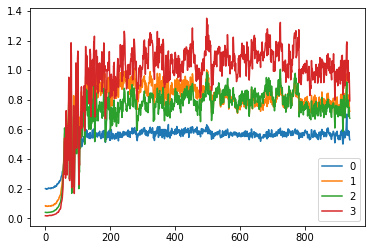

In [83]:
for hook in hooks:
    plt.plot(hook.stats[0])
    hook.remove()
plt.legend(range(4));

In [84]:
#export
class Hooks(ListContainer):
    def __init__(self, layers, hook_func): super().__init__([Hook(layer, hook_func) for layer in layers])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [119]:
runner, learner = examples.get_mnist_cnn(mnist_data)
hooks = Hooks(learner.model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x129e1ccf8>, <__main__.Hook object at 0x125c8a6a0>, <__main__.Hook object at 0x1268d4be0>, <__main__.Hook object at 0x1268d4da0>, <__main__.Hook object at 0x1268d4c50>, <__main__.Hook object at 0x1268d4f28>, <__main__.Hook object at 0x129b79978>]

train: [0.61106015625, 78.788]
valid: [0.190746044921875, 94.07]
train: [0.103172568359375, 96.798]
valid: [0.07482586059570312, 97.83]


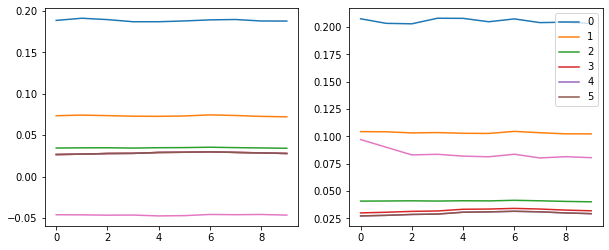

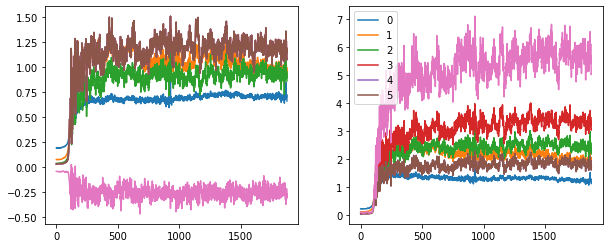

In [120]:
with Hooks(learner.model, append_stats) as hooks:
    runner.fit(2, learner)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hist = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hist = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

In [121]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

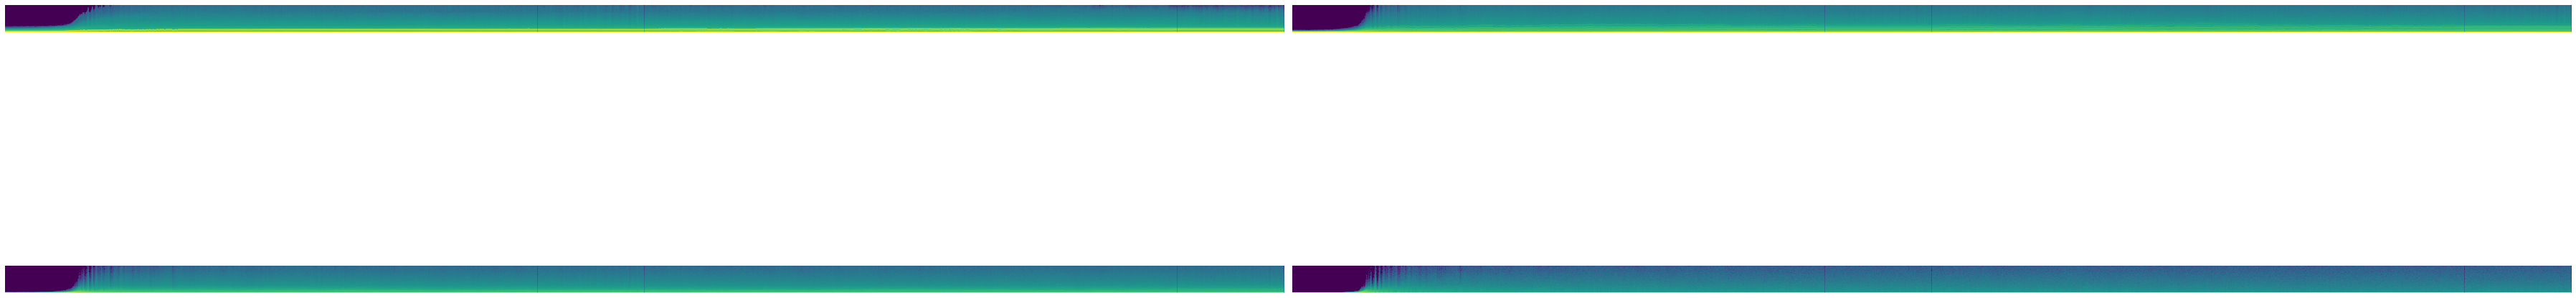

In [124]:
fig,axes = plt.subplots(2,2, figsize=(50,15))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [125]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0)

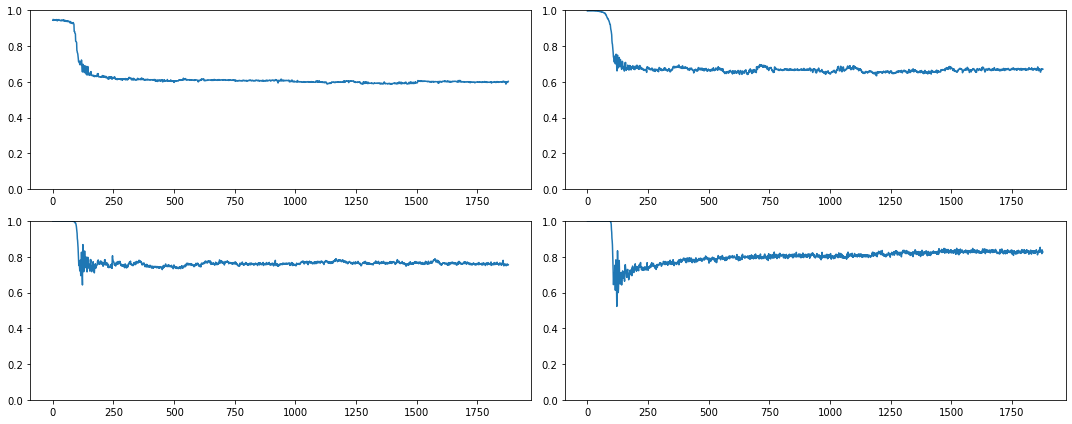

In [126]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

## Export

In [47]:
!python notebook2script.py stats_dev.ipynb fastml/model/stats.py

Converted stats_dev.ipynb to fastml/model/stats.py
